In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

In [43]:
tweets=pd.read_csv("400_USA_Labelled.csv")

In [47]:
tweets

,Text,pos_tagged_words,words_list,new_text,scores,compound,sentiment_vader
0,this was response post praising pfizer vaccine...,"[('this', 'DT'), ('was', 'VBD'), ('response', ...","['response', 'post', 'praise', 'pfizer', 'vacc...",response post praise pfizer vaccine april gop ...,"{'neg': 0.072, 'neu': 0.785, 'pos': 0.143, 'co...",0.4767,negative
1,les van poner pfizer pinches morrillos cagason...,"[('they', 'PRP'), ('re', 'VBP'), ('going', 'VB...","['go', 'put', 'pfizer', 'fuck', 'lucky', 'shit...",go put pfizer fuck lucky shithead go get vacci...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,negative
2,after may 2nd pfizer vax 6 days id be glad go ...,"[('after', 'IN'), ('may', 'MD'), ('and', 'CC')...","['may', 'pfizer', 'van', 'day', 'I', 'd', 'gla...",may pfizer van day I d glad go help work probl...,"{'neg': 0.146, 'neu': 0.685, 'pos': 0.17, 'com...",0.2023,positive
3,cher i got my second pfizer vaccine shot may 1...,"[('cher', 'NN'), ('i', 'NN'), ('got', 'VBD'), ...","['cher', 'get', 'second', 'pfizer', 'vaccine',...",cher get second pfizer vaccine shoot may est f...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
4,eso es con pfizer,"[('that', 'IN'), ('i', 'NN'), ('with', 'IN'), ...",['pfizer'],pfizer,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
...,...,...,...,...,...,...,...
395,"sleep. lots sleep. water. if you can take it, ...","[('sleep', 'JJ'), ('lots', 'NNS'), ('sleep', '...","['sleep', 'lot', 'sleep', 'water', 'take', 'ib...",sleep lot sleep water take ibuprofen painkille...,"{'neg': 0.079, 'neu': 0.82, 'pos': 0.101, 'com...",0.1779,positive
396,"once again,missed point. there's lot opposing ...","[('once', 'RB'), ('again', 'RB'), ('missed', '...","['miss', 'point', 'lot', 'oppose', 'informatio...",miss point lot oppose information govt medium ...,"{'neg': 0.075, 'neu': 0.854, 'pos': 0.07, 'com...",-0.0511,negative
397,nobody: want some sars-cov-2 spike proteins my...,"[('nobody', 'NN'), ('want', 'VBP'), ('some', '...","['nobody', 'want', 'sars_cov', 'two', 'spike_p...",nobody want sars_cov two spike_protein body ge...,"{'neg': 0.0, 'neu': 0.902, 'pos': 0.098, 'comp...",0.0772,neutral
398,finally out quarantine so time get dose 1/2 3/...,"[('finally', 'RB'), ('out', 'RP'), ('quarantin...","['finally', 'quarantine', 'time', 'get', 'dose...",finally quarantine time get dose one two three...,"{'neg': 0.0, 'neu': 0.794, 'pos': 0.206, 'comp...",0.7579,positive


In [44]:
import numpy as np
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(ngram_range=(1,2))

In [46]:
vectorized_data = count_vectorizer.fit_transform(tweets.new_text)
indexed_data = hstack((np.array(range(0,vectorized_data.shape[0]))[:,None], vectorized_data))

In [48]:
def sentiment2target(sentiment):
    return {
        'negative': 0,
        'neutral': 1,
        'positive' : 2
    }[sentiment]
targets = tweets.sentiment_vader.apply(sentiment2target)

In [49]:
from sklearn.model_selection import train_test_split
data_train, data_test, targets_train, targets_test = train_test_split(indexed_data, targets, test_size=0.4, random_state=0)
data_train_index = data_train[:,0]
data_train = data_train[:,1:]
data_test_index = data_test[:,0]
data_test = data_test[:,1:]

In [50]:
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(svm.SVC(gamma=0.01, C=100., probability=True, class_weight='balanced', kernel='linear'))
clf_output = clf.fit(data_train, targets_train)

In [51]:
clf.score(data_test, targets_test)

0.48125

In [52]:
sentences = count_vectorizer.transform([
    "What a great airline, the trip was a pleasure!",
    "My issue was quickly resolved after calling customer support. Thanks!",
    "What the hell! My flight was cancelled again. This sucks!",
    "Service was awful. I'll never fly with you again.",
    "You fuckers lost my luggage. Never again!",
    "I have mixed feelings about airlines. I don't know what I think.",
    ""
])
clf.predict_proba(sentences)

array([[0.38771165, 0.22669181, 0.38559654],
       [0.35114839, 0.22558498, 0.42326663],
       [0.36334287, 0.21725823, 0.4193989 ],
       [0.41672458, 0.19431191, 0.38896352],
       [0.43294559, 0.19694624, 0.37010817],
       [0.36806608, 0.28651297, 0.34542095],
       [0.36519232, 0.23682529, 0.39798239]])

In [53]:
predictions_on_test_data = clf.predict_proba(data_test)
index = np.transpose(np.array([range(0,len(predictions_on_test_data))]))
indexed_predictions = np.concatenate((predictions_on_test_data, index), axis=1).tolist()

In [55]:
def marginal(p):
    top2 = p.argsort()[::-1]
    return abs(p[top2[0]]-p[top2[1]])
margin = sorted(list(map(lambda p : [marginal(np.array(p[0:3])),p[3]], indexed_predictions)), key=lambda p : p[0])
list(map(lambda p : tweets.iloc[data_test_index[int(p[1])].toarray()[0][0]].new_text, margin[0:10]))

['yes want get another vaccine scare hit jansen badly want get pfizer think go give astrazeneca want one anyway like well protect',
 'every day ton news story pfizer vaccine really wish data news johnson amp johnson vaccine know one get',
 'dad either get third pfizer shoot placebo tomorrow part study',
 'actually ask houdini vaccine disappear happen',
 'renault already two pfizer',
 'yes indeed mistake accept',
 'definitely new one lol anyway think mdma safe pfizer covid vaccine thread either grossly uninformed imbecile',
 'well see second dose pfizer fall think go errand',
 'believe pfizer say datum show well biden cac say booster need listen science world health origination criticize wealthy country go booster shot many country vaccine',
 'test negative I m going to start double_maske pfizer come third dose imma first line get shir']

In [56]:
list(map(lambda p : predictions_on_test_data[int(p[1])], margin[0:10]))


[array([0.34957086, 0.30119914, 0.34923   ]),
 array([0.26936426, 0.36507041, 0.36556533]),
 array([0.28576658, 0.35522268, 0.35901074]),
 array([0.40247043, 0.20021306, 0.39731651]),
 array([0.17239745, 0.41815831, 0.40944424]),
 array([0.36324606, 0.26470198, 0.37205196]),
 array([0.35363886, 0.34300999, 0.30335115]),
 array([0.25308425, 0.3833715 , 0.36354425]),
 array([0.49660015, 0.02786186, 0.47553799]),
 array([0.20678221, 0.38354698, 0.40967081])]

In [58]:
list(map(lambda p : tweets.iloc[data_test_index[int(p[1])].toarray()[0][0]].new_text, margin[-10:]))


['nieces home fed employee husband get one shot pfizer delay second long possible accord malone creator pfizer low dosage spike_protein sad many put position experimental drug lose job',
 'pfizer pronounce pfizer',
 'yeah bad mean not bad like yeah day like whatever yeah get pfizer',
 'think comparable pfizer study site many country modern u trial',
 'davos economic_forum corrupt sit ceos modern pfizer many other',
 'unfortunate ignorant infected earn mother wear face mask already vaccinate pfizer not stop wear face mask take care doubt know charles darwin theory natural selection explain everything',
 'eight four ucs_fresno covid nineteen equity project back uc merce fresno center e shaw ave fashion fair mall fresno free pfizer amp vaccine free testing seven day week sit amp sun two tu eleven',
 'calm pfizer modern one indicate issue do arduous research study neurologist join pfizer despite fact compris already approve modern government not',
 'get tiny little je prick looking_forward

In [59]:
list(map(lambda p : predictions_on_test_data[int(p[1])], margin[-10:]))


[array([0.21050434, 0.61088678, 0.17860888]),
 array([0.20165692, 0.62189654, 0.17644654]),
 array([0.67892505, 0.06280337, 0.25827158]),
 array([0.19054025, 0.6196788 , 0.18978095]),
 array([0.19432813, 0.62663926, 0.17903262]),
 array([0.66176171, 0.1426916 , 0.19554669]),
 array([0.18834528, 0.14939852, 0.66225621]),
 array([0.22326435, 0.71161288, 0.06512277]),
 array([0.15818097, 0.67478582, 0.16703321]),
 array([0.09260638, 0.17813421, 0.72925942])]

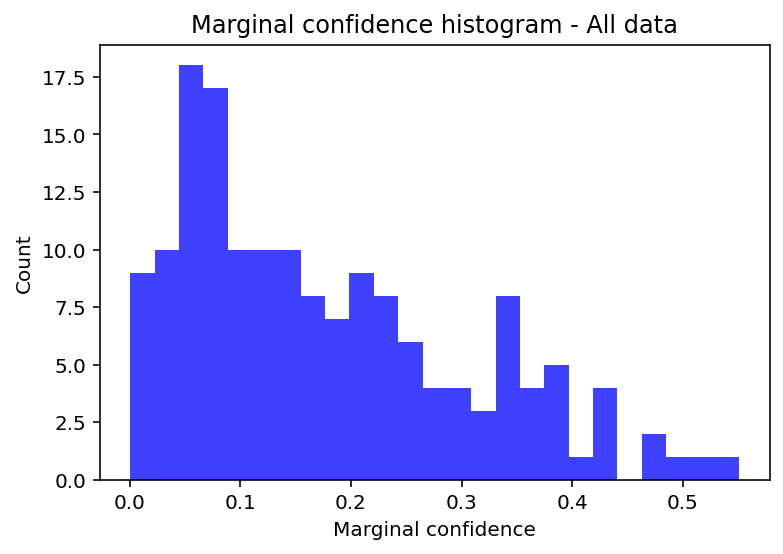

In [60]:
import matplotlib.pyplot as plt
marginal_probs = list(map(lambda p : p[0], margin))
n, bins, patches = plt.hist(marginal_probs, 25, facecolor='blue', alpha=0.75)
plt.title('Marginal confidence histogram - All data')
plt.ylabel('Count')
plt.xlabel('Marginal confidence')
plt.show()

### POSITIVE DATA

/var/folders/d0/5_1bb8ld291843m4x7vj7vnw0000gn/T/ipykernel_1841/361584559.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  positive_test_data = list(filter(lambda row : row[0]==2, hstack((targets_test[:,None], data_test)).toarray()))


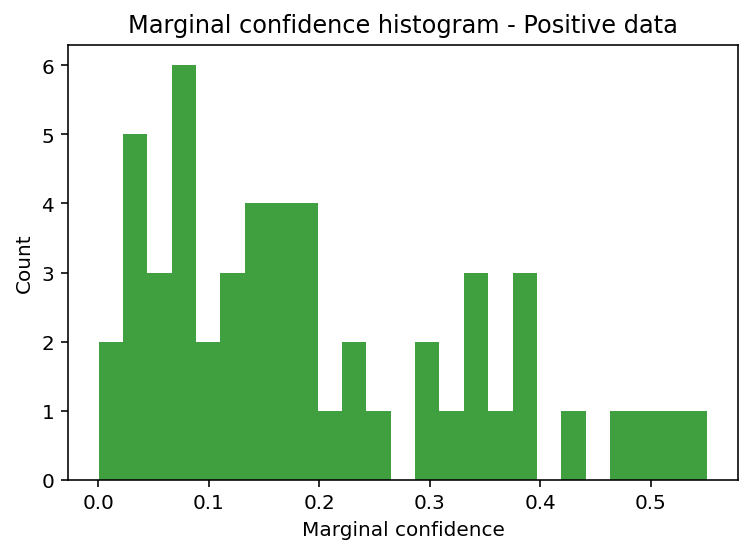

In [61]:
positive_test_data = list(filter(lambda row : row[0]==2, hstack((targets_test[:,None], data_test)).toarray()))
positive_probs = clf.predict_proba(list(map(lambda r : r[1:], positive_test_data)))
marginal_positive_probs = list(map(lambda p : marginal(p), positive_probs))
n, bins, patches = plt.hist(marginal_positive_probs, 25, facecolor='green', alpha=0.75)
plt.title('Marginal confidence histogram - Positive data')
plt.ylabel('Count')
plt.xlabel('Marginal confidence')
plt.show()


### NEUTRAL DATA

/var/folders/d0/5_1bb8ld291843m4x7vj7vnw0000gn/T/ipykernel_1841/4051263430.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  neutral_test_data = list(filter(lambda row : row[0]==1, hstack((targets_test[:,None], data_test)).toarray()))


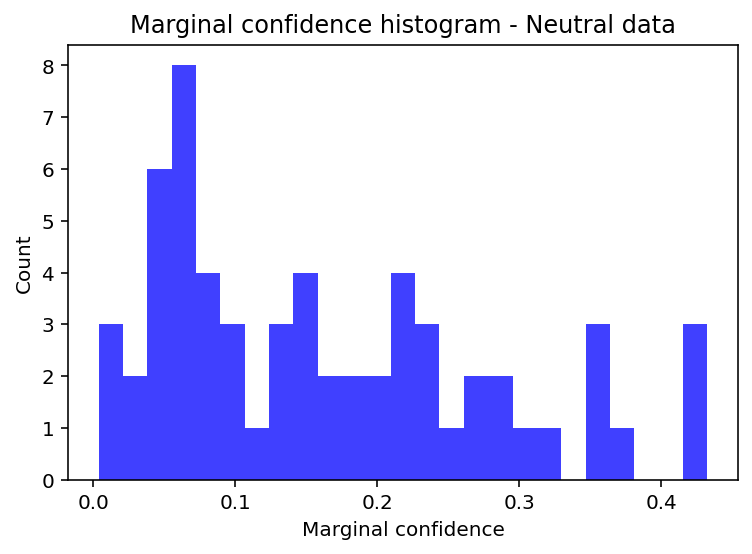

In [63]:
neutral_test_data = list(filter(lambda row : row[0]==1, hstack((targets_test[:,None], data_test)).toarray()))
neutral_probs = clf.predict_proba(list(map(lambda r : r[1:], neutral_test_data)))
marginal_neutral_probs = list(map(lambda p : marginal(p), neutral_probs))
n, bins, patches = plt.hist(marginal_neutral_probs, 25, facecolor='blue', alpha=0.75)
plt.title('Marginal confidence histogram - Neutral data')
plt.ylabel('Count')
plt.xlabel('Marginal confidence')
plt.show()

### NEGATIVE DATA

/var/folders/d0/5_1bb8ld291843m4x7vj7vnw0000gn/T/ipykernel_1841/2889540462.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  negative_test_data = list(filter(lambda row : row[0]==0, hstack((targets_test[:,None], data_test)).toarray()))


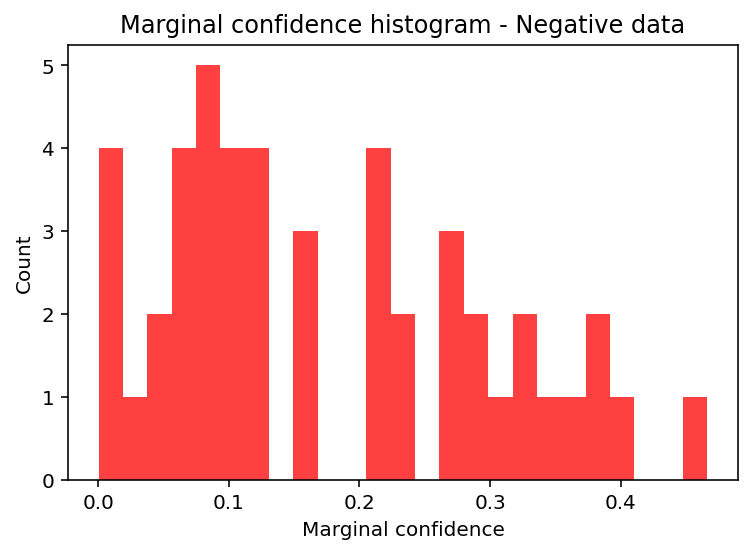

In [64]:
negative_test_data = list(filter(lambda row : row[0]==0, hstack((targets_test[:,None], data_test)).toarray()))
negative_probs = clf.predict_proba(list(map(lambda r : r[1:], negative_test_data)))
marginal_negative_probs = list(map(lambda p : marginal(p), negative_probs))
n, bins, patches = plt.hist(marginal_negative_probs, 25, facecolor='red', alpha=0.75)
plt.title('Marginal confidence histogram - Negative data')
plt.ylabel('Count')
plt.xlabel('Marginal confidence')
plt.show()